# Fuel Economy Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import HuberRegressor
from sklearn.preprocessing import OneHotEncoder
import numpy as np

sns.set_style("whitegrid")

Load data.

In [2]:
car_data = pd.read_excel("./data/carEcon.xlsx", sheet_name='carData', dtype={'Drive': str})
car_test = pd.read_excel("./data/carEcon.xlsx", sheet_name='carTest', dtype={'Drive': str})
X_test, y_test = car_test.iloc[:, :-1], car_test.iloc[:, -1]
car_train = pd.read_excel("./data/carEcon.xlsx", sheet_name='carTrain', dtype={'Drive': str})
X_train, y_train = car_train.iloc[:, :-1], car_train.iloc[:, -1]
categorical_columns = X_train.select_dtypes(include=['object']).columns
numeric_columns = X_train.select_dtypes(include=[np.number]).columns
car_data.head()

,Car_Truck,EngDisp,RatedHP,Transmission,Drive,Weight,Comp,AxleRatio,EVSpeedRatio,AC,PRP,FuelType,City_Highway,Valves_Cyl,FuelEcon
0,truck,4.1623,350,L6,4,2721.6,12.5,4.32,35.9,N,1,61,city,8,15.6810
1,car,2.4745,150,L6,F,1530.9,9.5,3.50,32.7,N,31,61,highway,5,6.0622
2,car,2.4417,168,L5,F,1757.7,10.3,2.44,34.6,N,31,23,highway,5,6.2724
3,truck,2.2942,133,AV,4,1814.4,12.3,3.73,31.2,Y,31,61,city,4,6.5702
4,truck,3.3102,208,AV,4,2154.6,10.8,3.54,23.7,N,31,61,highway,6,6.7397


Encode categorical columns.

In [3]:
encoder = OneHotEncoder(drop='if_binary')
X_train_encoded = encoder.fit_transform(X_train[categorical_columns]).toarray()
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out())
X_train_encoded = pd.concat((X_train[numeric_columns], X_train_encoded), axis=1)
X_train_encoded.head()

,EngDisp,RatedHP,Weight,Comp,AxleRatio,EVSpeedRatio,PRP,FuelType,Valves_Cyl,Car_Truck_truck,...,Transmission_M6,Transmission_S4,Transmission_S5,Transmission_S6,Transmission_S7,Drive_4,Drive_F,Drive_R,AC_Y,City_Highway_highway
0,1.6059,110,1304.1,10.0,4.04,42.0,1,61,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.9992,150,1417.5,10.0,3.68,37.6,31,61,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1.9992,150,1417.5,10.0,3.68,37.4,31,61,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,2.3597,158,1644.3,9.8,3.39,31.9,31,61,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,2.2942,160,1587.6,9.7,3.86,36.3,31,61,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


Fit model.

In [4]:
regressor = HuberRegressor(max_iter=10000)
regressor.fit(X_train_encoded, y_train)

HuberRegressor(max_iter=10000)

Test model.

In [5]:
X_test_encoded = encoder.transform(X_test[categorical_columns]).toarray()
X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out())
X_test_encoded = pd.concat((X_test[numeric_columns], X_test_encoded), axis=1)

y_pred = regressor.predict(X_test_encoded)
print("R^2:", regressor.score(X_test_encoded, y_test))

R^2: 0.7785167603726009


Plot predictions.

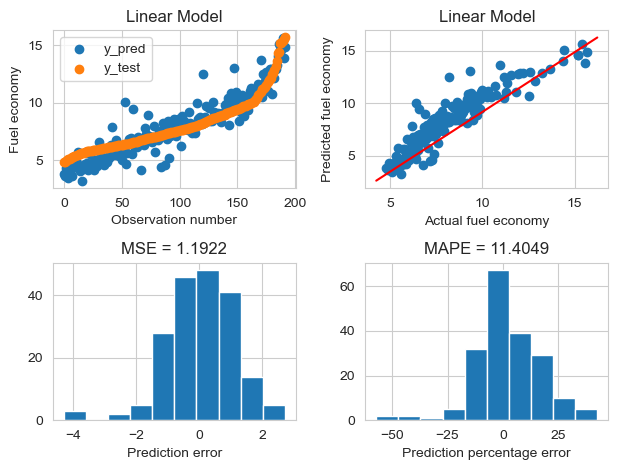

In [6]:
fig, axs = plt.subplots(2, 2)

# Plot against observation number
axs[0, 0].scatter(range(len(y_pred)), y_pred)
axs[0, 0].scatter(range(len(y_test)), y_test)
axs[0, 0].set_xlabel('Observation number')
axs[0, 0].set_ylabel('Fuel economy')
axs[0, 0].legend(["y_pred", "y_test"])
axs[0, 0].set_title("Linear Model")

# Plot predicted and actual against each other
axs[0, 1].scatter(y_test, y_pred)
xlim = axs[0, 1].get_xlim()
ylim = axs[0, 1].get_ylim()
axs[0, 1].plot(xlim, ylim, color='r')
axs[0, 1].set_xlabel('Actual fuel economy')
axs[0, 1].set_ylabel('Predicted fuel economy')
axs[0, 1].set_title("Linear Model")

# Distribution of errors
error = y_test - y_pred
MSE = np.mean(error**2)
axs[1, 0].hist(error)
axs[1, 0].set_title('MSE = {:.4f}'.format(MSE))
axs[1, 0].set_xlabel('Prediction error')

# Distribution of percentage errors
error = 100 * error / y_test
MSE = np.mean(np.abs(error))
axs[1, 1].hist(error)
axs[1, 1].set_title('MAPE = {:.4f}'.format(MSE))
axs[1, 1].set_xlabel('Prediction percentage error')

plt.tight_layout()
plt.show()